## Linear regression model for car price forecasting

Importing all necessary modules

In [2636]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import itertools as it

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.model_selection import cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
import category_encoders as ce
from statsmodels.graphics.regressionplots import *

import eli5
from eli5.sklearn import PermutationImportance

import seaborn as sns
sns.set()

# Data cleanzing and transforming functions

In [2637]:
def outliers_remove(dataset):
    
#remove outliers based on interquantile range
    for col in dataset.select_dtypes(['float64','int64']):
        
        iqr=dataset[col].quantile(0.75)-dataset[col].quantile(0.25)
        dataset=dataset[dataset[col]<=dataset[col].quantile(0.75)+iqr*3]
        dataset=dataset[dataset[col]>=dataset[col].quantile(0.25)-iqr*3]
        
    return dataset


In [2638]:
def leverage_remove(dataset, X_train,y_train):
    
#     y_lev=dataset.Price
#     X_lev=dataset.drop('Price',axis=1)
#     X_lev=X_lev.select_dtypes(['float64','int64'])

    X_lev=X_train.select_dtypes(['float64','int64'])
    model_lev = sm.OLS(y_train, sm.add_constant(X_lev)).fit()

    influence = model_lev.get_influence()
    student_resid = influence.resid_studentized_external
    leverage = influence.hat_matrix_diag
    inf_sum = influence.summary_frame()

    sns.regplot(leverage, model_lev.resid_pearson,  fit_reg=False)
    plt.title('Leverage vs. Studentized Residuals')
    plt.xlabel('Leverage')
    plt.ylabel('Studentized Residuals')
    plt.show()

    price_res = pd.concat([y_train, inf_sum], axis = 1)
    price_res=price_res.rename(columns={'hat_diag': 'leverage'})

    r = price_res.student_resid
    print ('Outliers:', price_res.Price[abs(r) > 3].count())
    outliers= price_res.Price[abs(r) > 3]
    l = price_res.leverage
    print ('High leverage:',price_res.Price[abs(l) > ((2*X_train.shape[1])+2)/X_train.shape[0]].count())
    leverage =price_res.Price[abs(l) > ((2*X_train.shape[1])+2)/X_train.shape[0]]

    outliers_index = outliers.index
    leverage_index = leverage.index
    data_index = dataset.index


    data=dataset[data_index.isin(outliers_index)==False]
    data=dataset[data_index.isin(leverage_index)==False]


    return data

In [2639]:
def numerical_preprocessor(X_train):
    # Select numerical columns
    numerical_cols = [cname for cname in X_train.columns if X_train[cname].dtype in ['int64', 'float64']]

    # Preprocessing for numerical data
    numerical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', StandardScaler())])
    
    X_transformed=X_train.copy()
    X_transformed[numerical_cols]=numerical_transformer.fit_transform(X_train[numerical_cols])
    
    return X_transformed

In [2640]:
def big_categorical_preprocessor (X_train, y_train):
    # Select categorical columns with relatively high cardinality 
    big_categorical_cols = [cname for cname in X_train.columns if X_train[cname].nunique() >= 10 and 
                            X_train[cname].dtype == "object"]
    # Preprocessing
    big_categorical_transformer=ce.TargetEncoder(cols=big_categorical_cols)
    
    X_transformed=X_train.copy()
    X_transformed[big_categorical_cols]=big_categorical_transformer.fit_transform(X_train[big_categorical_cols], y_train)
    
    return X_transformed

In [2641]:
def pipeline_preprocessing(X_train):
    
    # Select categorical columns with relatively low and high cardinality 
    
    categorical_cols = [cname for cname in X_train.columns if X_train[cname].nunique() < 10 and 
                            X_train[cname].dtype == "object"]

    big_categorical_cols = [cname for cname in X_train.columns if X_train[cname].nunique() >= 10 and 
                            X_train[cname].dtype == "object"]

    # Select numerical columns
    numerical_cols = [cname for cname in X_train.columns if X_train[cname].dtype in ['int64', 'float64']]

    # Preprocessing for numerical data
    numerical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', StandardScaler())])

    # Preprocessing for categorical data
    categorical_transformer = OneHotEncoder(sparse=False, drop='first')

    big_categorical_transformer=ce.TargetEncoder()


    # Bundle preprocessing for numerical and categorical data
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numerical_transformer, numerical_cols),
            ('cat', categorical_transformer, categorical_cols),
            ('big_cat',big_categorical_transformer, big_categorical_cols)])
    
    return preprocessor

# Features functions

In [2642]:
def multicolinearity_check(X):
    variables=X.select_dtypes(['float64','int64'])
    vif = pd.DataFrame()
    vif["VIF"] = [variance_inflation_factor(variables.values, i) for i in range(variables.shape[1])]
    vif["features"] = variables.columns
    return vif

In [2643]:
def create_interactions(dataset):
    cat_features = dataset.select_dtypes('object').columns
    name=""
    for item in it.combinations(cat_features, 2):
        name=item[0]+"_"+item[1]
        dataset[name]=dataset[item[0]].astype('str')+"_"+dataset[item[1]].astype('str')
    
    return dataset

In [2644]:
def features_importance(X_train, y_train):
    
    model=LinearRegression()
    X_tocheck=X_train.select_dtypes(['float64','int64'])

    model.fit(X_tocheck, y_train)
    perm = PermutationImportance(model, random_state=0).fit(X_tocheck, y_train)
    return eli5.show_weights(perm, feature_names = X_tocheck.columns.tolist())
    

# Modeling fucntions

Fit OLS model from statsmodel to check regression summary

In [2645]:
def OLS_with_summary(X_train, y_train):
    
    X_train_OLS = pd.get_dummies(X_train, drop_first=True)
    
    
    X = sm.add_constant(X_train_OLS)
    model_OLS = sm.OLS(y_train,X)
    results = model_OLS.fit()
    #return linear regression summary
    return results.summary()

Fit sklearn pipeline with linear regression

In [2695]:
def pipeline_fit(X_train,y_train):
    
    
#     categorical_cols = [cname for cname in X_train.columns if X_train[cname].nunique() < 10 and 
#                             X_train[cname].dtype == "object"]
#     X_dummies = pd.get_dummies(X_train[categorical_cols], drop_first=True)
#     X_train=X_train.join(X_dummies)
                        
    preprocessor=pipeline_preprocessing(X_train)
    model=LinearRegression()
    
    # Bundle preprocessing and modeling code in a pipeline
    my_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('model', model)])

    # Preprocessing of training data, fit model 
    my_pipeline=my_pipeline.fit(X_train, y_train)
    print('R2: {}, Intercept: {}'.format(my_pipeline.score(X_train, y_train).round(decimals=3), my_pipeline.named_steps['model'].intercept_.round(decimals=3)))
    return my_pipeline

In [2710]:
def predictions(X_train, y_train, X_test, y_test):
    
    pipeline=pipeline_fit(X_train,y_train)

    # Preprocessing of validation data, get predictions
    preds = pipeline.predict(X_test)    
    

    #Create data frame with predictions and residuals
    predictions=pd.DataFrame(preds, columns=['Prediction'])
    y_test = y_test.reset_index(drop=True)
    
    predictions['Target']=y_test
    predictions['Residuals']=predictions['Target']-predictions['Prediction']
    predictions['Difference%'] = np.absolute(predictions['Residuals']/predictions['Target']*100)
    
    # Evaluate the model
    score = mean_absolute_error(y_test, preds)
    MAPE=abs(predictions['Residuals'].sum())/predictions['Target'].sum()*100
    
    print('MAE:', score.round(decimals=3))
    print('MAPE:', MAPE.round(decimals=3))
    
    return predictions


In [2648]:
data = pd.read_csv('1.04. Real-life example.csv')
data.head()

,Brand,Price,Body,Mileage,EngineV,Engine Type,Registration,Year,Model
0,BMW,4200.0,sedan,277,2.0,Petrol,yes,1991,320
1,Mercedes-Benz,7900.0,van,427,2.9,Diesel,yes,1999,Sprinter 212
2,Mercedes-Benz,13300.0,sedan,358,5.0,Gas,yes,2003,S 500
3,Audi,23000.0,crossover,240,4.2,Petrol,yes,2007,Q7
4,Toyota,18300.0,crossover,120,2.0,Petrol,yes,2011,Rav 4


In [2649]:
data.describe(include='all')

,Brand,Price,Body,Mileage,EngineV,Engine Type,Registration,Year,Model
count,4345,4173.000000,4345,4345.000000,4195.000000,4345,4345,4345.000000,4345
unique,7,NaN,6,NaN,NaN,4,2,NaN,312
top,Volkswagen,NaN,sedan,NaN,NaN,Diesel,yes,NaN,E-Class
freq,936,NaN,1649,NaN,NaN,2019,3947,NaN,199
mean,NaN,19418.746935,NaN,161.237284,2.790734,NaN,NaN,2006.550058,NaN
std,NaN,25584.242620,NaN,105.705797,5.066437,NaN,NaN,6.719097,NaN
min,NaN,600.000000,NaN,0.000000,0.600000,NaN,NaN,1969.000000,NaN
25%,NaN,6999.000000,NaN,86.000000,1.800000,NaN,NaN,2003.000000,NaN
50%,NaN,11500.000000,NaN,155.000000,2.200000,NaN,NaN,2008.000000,NaN
75%,NaN,21700.000000,NaN,230.000000,3.000000,NaN,NaN,2012.000000,NaN


In [2650]:
data.dropna(subset=['Price'],axis=0,inplace=True)

G:\Anaconda\lib\site-packages\numpy\lib\histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
G:\Anaconda\lib\site-packages\numpy\lib\histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


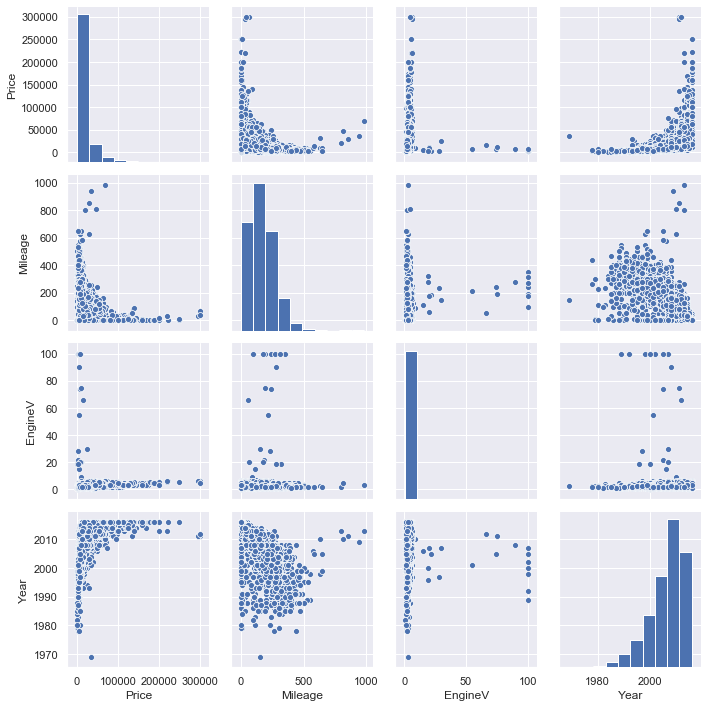

In [2651]:
sns.pairplot(data.select_dtypes(['float64','int64']), height=2.5)
plt.tight_layout()

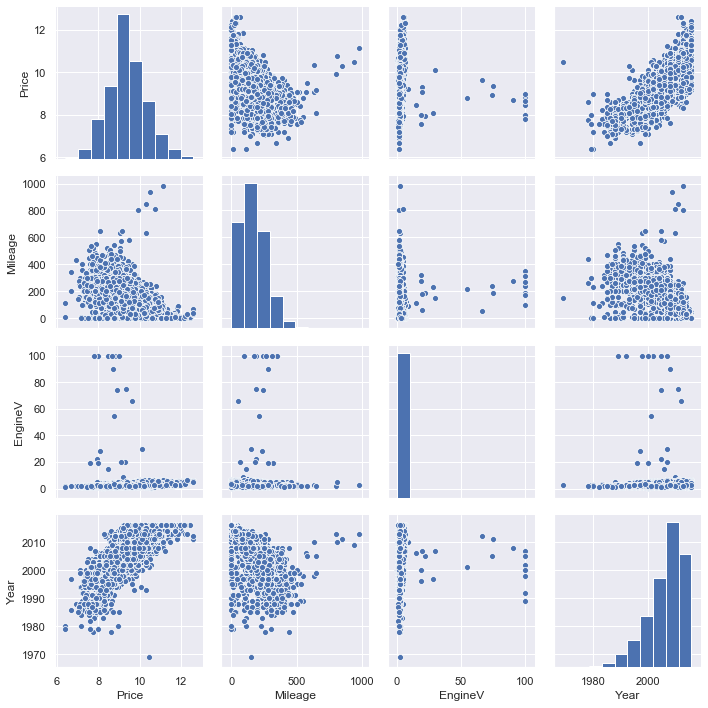

In [2652]:
data['Price']= np.log(data['Price'])
data['Registration']=data['Registration'].replace({'yes':True,'no':False})

sns.pairplot(data.select_dtypes(['float64','int64']), height=2.5)
plt.tight_layout()

In [2653]:
data_clean=outliers_remove(data)
data_clean.describe()

,Price,Mileage,EngineV,Year
count,3999.000000,3999.000000,3999.000000,3999.000000
mean,9.412329,162.861465,2.467074,2006.400850
std,0.932747,101.697805,0.975320,6.670597
min,6.396930,0.000000,0.600000,1978.000000
25%,8.853665,90.000000,1.800000,2003.000000
50%,9.350102,158.000000,2.200000,2008.000000
75%,9.994242,230.000000,3.000000,2012.000000
max,12.611538,650.000000,6.500000,2016.000000


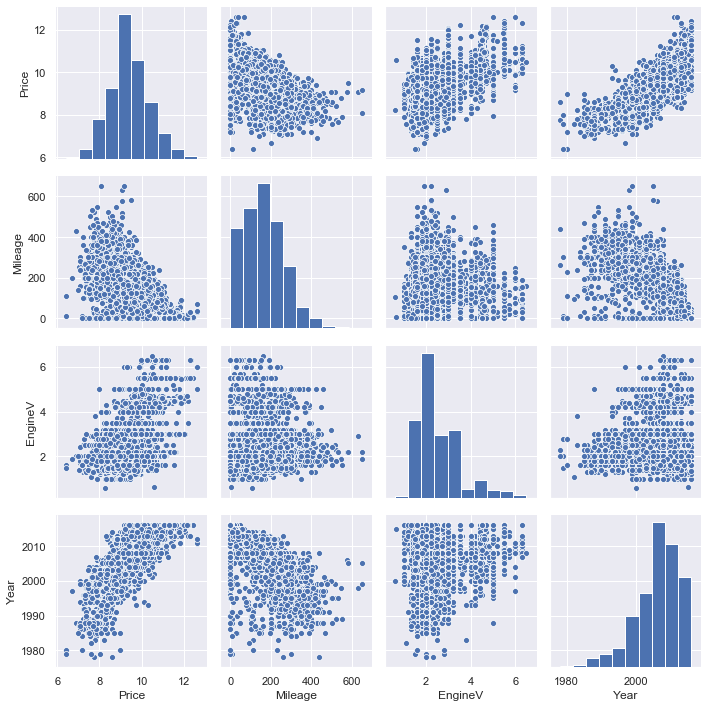

In [2654]:
sns.pairplot(data_clean.select_dtypes(['float64','int64']), height=2.5)
plt.tight_layout()

In [2655]:
y=data_clean.Price
X=data_clean.drop(['Price'], axis=1)

In [2656]:
VIF=multicolinearity_check(X)
VIF

,VIF,features
0,3.543270,Mileage
1,7.412518,EngineV
2,10.221611,Year


In [2657]:
data_clean['Year']=data_clean['Year'].astype('str')
X=data_clean.drop(['Price'], axis=1)
VIF_without_Year=multicolinearity_check(X)
VIF_without_Year

,VIF,features
0,2.56668,Mileage
1,2.56668,EngineV


In [2658]:
data_interactions=create_interactions(data_clean)
y=data_interactions.Price
X=data_interactions.drop(['Price'], axis=1)

In [2659]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [2660]:
X_train_transformed=numerical_preprocessor(X_train)
X_train_transformed=big_categorical_preprocessor(X_train_transformed,y_train)
X_train_transformed.head()

,Brand,Body,Mileage,EngineV,Engine Type,Registration,Year,Model,Brand_Body,Brand_Engine Type,Brand_Year,Brand_Model,Body_Engine Type,Body_Year,Body_Model,Engine Type_Year,Engine Type_Model,Year_Model
3462,Mitsubishi,van,0.369667,-0.884701,Petrol,True,8.936342,8.181308,8.669668,9.001411,8.775441,8.181308,9.150122,8.739442,8.388139,9.068311,8.181308,9.406463
1993,Mercedes-Benz,crossover,-1.603691,0.551402,Petrol,True,10.921946,11.336941,10.842630,10.053262,11.576689,11.336941,10.269742,11.212091,11.339733,10.909789,9.406463,11.336941
169,BMW,sedan,0.961675,-0.679543,Petrol,False,8.266565,8.476478,9.224291,9.586020,8.170860,8.476478,9.322523,8.236246,8.439704,8.267268,8.521421,8.049294
211,BMW,sedan,1.030742,-0.474386,Gas,True,8.180199,9.571299,9.224291,9.091698,8.436199,9.571299,9.024340,8.204022,9.594835,8.377228,8.966457,8.725797
667,Renault,van,0.863007,-0.576965,Diesel,True,9.186322,9.135719,8.829141,8.948475,8.723521,9.135719,9.188160,8.880269,9.125643,9.058971,9.143656,8.907433


In [2661]:
features_importance(X_train_transformed, y_train)

Weight,Feature
0.2967 ± 0.0129,Brand_Model
0.2867 ± 0.0212,Model
0.2133 ± 0.0086,Brand_Year
0.0796 ± 0.0041,EngineV
0.0599 ± 0.0039,Body_Year
0.0466 ± 0.0023,Engine Type_Model
0.0219 ± 0.0044,Year_Model
0.0205 ± 0.0025,Year
0.0082 ± 0.0009,Engine Type_Year
0.0011 ± 0.0005,Body_Engine Type


In [2662]:
VIF_with_interactions=multicolinearity_check(X_train_transformed)
VIF_with_interactions

,VIF,features
0,2.032344,Mileage
1,1.704251,EngineV
2,4191.535541,Year
3,472370.269821,Model
4,1748.217867,Brand_Body
5,735.812238,Brand_Engine Type
6,1158.861201,Brand_Year
7,469081.774584,Brand_Model
8,1687.296244,Body_Engine Type
9,1975.152805,Body_Year


In [2663]:
X_train_final=X_train_transformed.drop(['Model','Year','Engine Type_Year','Brand_Model','Brand_Body','Body_Model','Brand_Engine Type','Body_Year','Engine Type_Model','Year_Model','Body_Engine Type'],axis=1)
VIF_final=multicolinearity_check(X_train_final)
VIF_final

,VIF,features
0,1.004523,Mileage
1,1.001799,EngineV
2,1.003519,Brand_Year


In [2664]:
features_importance(X_train_final, y_train)

Weight,Feature
1.0764 ± 0.0197,Brand_Year
0.1434 ± 0.0126,EngineV
0.0221 ± 0.0019,Mileage


In [2684]:
cols=[cname for cname in X_test.columns if cname in X_train_final.columns]

X_test_final=X_test[cols]
X_train_final=X_train[cols]

In [2685]:
X_train_final['Registration']=X_train_final['Registration'].astype('str')

X_train_transformed_final=numerical_preprocessor(X_train_final)
X_train_transformed_final=big_categorical_preprocessor(X_train_transformed_final,y_train)


OLS_with_summary(X_train_transformed_final, y_train)

              Brand       Body   Mileage   EngineV Engine Type Registration  \
3462     Mitsubishi        van  0.369667 -0.884701      Petrol         True   
1993  Mercedes-Benz  crossover -1.603691  0.551402      Petrol         True   
169             BMW      sedan  0.961675 -0.679543      Petrol        False   
211             BMW      sedan  1.030742 -0.474386         Gas         True   
667         Renault        van  0.863007 -0.576965      Diesel         True   

      Brand_Year  
3462    8.775441  
1993   11.576689  
169     8.170860  
211     8.436199  
667     8.723521  


G:\Anaconda\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
G:\Anaconda\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Price   R-squared:                       0.883
Model:                            OLS   Adj. R-squared:                  0.883
Method:                 Least Squares   F-statistic:                     1340.
Date:                Wed, 12 Feb 2020   Prob (F-statistic):               0.00
Time:                        01:22:33   Log-Likelihood:                -895.06
No. Observations:                3199   AIC:                             1828.
Df Residuals:                    3180   BIC:                             1943.
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   1.6497      0.116     14.267      0.000       1.423       1.876
Mileage                -0.0808      0.009     -9.295      0.000      -0.098      -0.064
EngineV                 0.2532      0.007     35.420      0.000       0.239       0.267
Brand_Year              0.7905      0.012     66.550      0.000       0.767       0.814
Brand_BMW              -0.0544      0.023     -2.376      0.018      -0.099      -0.010
Brand_Mercedes-Benz    -0.1238      0.023     -5.457      0.000      -0.168      -0.079
Brand_Mitsubishi       -0.1366      0.029     -4.713      0.000      -0.193      -0.080
Brand_Renault           0.0363      0.028      1.304      0.192      -0.018       0.091
Brand_Toyota           -0.1623      0.025     -6.468      0.000      -0.211      -0.113
Brand_Volkswagen        0.0681      0.023      2.967      0.003       0.023       0.113
Body_hatch             -0.3384      0.029    -11.584      0.000      -0.396      -0.281
Body_other             -0.1553      0.024     -6.556      0.000      -0.202      -0.109
Body_sedan             -0.2077      0.018    -11.440      0.000      -0.243      -0.172
Body_vagon             -0.2123      0.025     -8.338      0.000      -0.262      -0.162
Body_van               -0.3038      0.024    -12.919      0.000      -0.350      -0.258
Engine Type_Gas        -0.1102      0.020     -5.606      0.000      -0.149      -0.072
Engine Type_Other      -0.1071      0.036     -2.935      0.003      -0.179      -0.036
Engine Type_Petrol     -0.1345      0.015     -8.910      0.000      -0.164      -0.105
Registration_True       0.6651      0.022     29.994      0.000       0.622       0.709
==============================================================================
Omnibus:                      827.508   Durbin-Watson:                   1.942
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             9551.779
Skew:                          -0.893   Prob(JB):                         0.00
Kurtosis:                      11.275   Cond. No.                         199.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [2705]:
cols=[cname for cname in X_test.columns if cname in X_train_final.columns]

X_test_final=X_test[cols]
X_train_final=X_train[cols]


In [2712]:
results=predictions(X_train_final,y_train, X_test_final, y_test)

R2: 0.851, Intercept: 1.276
MAE: 0.286
MAPE: 0.015


In [2707]:
print(results.sort_values(by=['Difference%']).tail(10))
results.describe()

     Prediction    Target  Residuals  Difference%
446    8.983699  7.787797  -1.195902    15.356105
454    8.547134  7.408531  -1.138604    15.368820
791    9.138510  7.824046  -1.314464    16.800313
538    8.590813  7.313220  -1.277592    17.469626
416    8.963733  7.600402  -1.363330    17.937606
329    9.321090  7.901007  -1.420083    17.973447
295    8.512966  7.170120  -1.342846    18.728369
183    8.669798  7.279319  -1.390480    19.101782
780    9.025089  7.575585  -1.449504    19.133888
130    8.964018  7.438384  -1.525635    20.510297


,Prediction,Target,Residuals,Difference%
count,800.000000,800.000000,800.000000,800.000000
mean,9.437158,9.435783,-0.001375,3.162984
std,0.834364,0.911932,0.389382,3.180327
min,7.304410,6.906755,-1.525635,0.001560
25%,8.842593,8.895630,-0.180652,1.030955
50%,9.333836,9.363052,0.034824,2.237426
75%,9.989501,9.975808,0.240570,4.131489
max,12.481953,12.611538,1.694978,20.510297


Text(0, 0.5, 'Residuals')

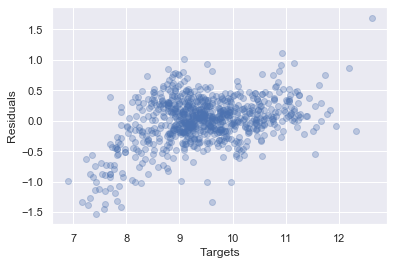

In [2708]:
plt.scatter(results['Target'],results['Residuals'],alpha=0.3)
plt.xlabel('Targets',size=12)
plt.ylabel('Residuals',size=12)

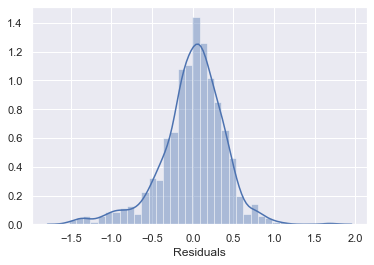

In [2711]:
sns.distplot(results['Residuals'])

(6.5, 12)

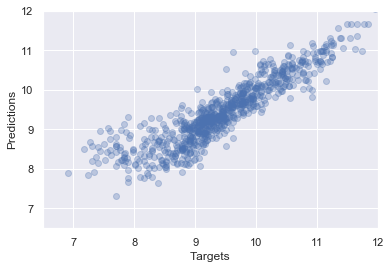

In [2714]:

plt.scatter(results['Target'],results['Prediction'],alpha=0.3)
plt.xlabel('Targets',size=12)
plt.ylabel('Predictions',size=12)
plt.xlim(6.5,12)
plt.ylim(6.5,12)


In [ ]:
# scores=cross_val_score(my_pipeline, X, y, cv=5)
# print('Accuracy:',scores.mean().round(decimals=3))